# Cleaning

This notebook follows my iterative process of exploring and cleaning the Florida highway patrol dataset from the Stanford Open Policing Project. The ultimate goal of this project is to use the information logged at individual traffic stops to predict when a stop will lead to an arrest.

The end result of this notebook is a cleaned dataset with all missing values removed. This reduced the number of observations from ~5 to 2.8 million, a drastic reduction but still a more than sufficient amount of data to work with.

## Package imports and settings

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Initial reading of and first look at data

Start by reading in just a few rows of the FL dataset to get a sense of the columns and datatypes.

In [2]:
df_fl_min = pd.read_csv('data/fl_statewide_2019_02_25.csv', nrows=50)

In [3]:
df_fl_min.head(10)

,raw_row_number,date,time,location,county_name,subject_age,subject_race,subject_sex,officer_id_hash,officer_age,officer_race,officer_sex,officer_years_of_service,department_name,unit,type,violation,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,search_basis,reason_for_search,vehicle_registration_state
0,1|1402189,2010-01-01,23:11:16,NaN,SARASOTA,24,NaN,female,e15ccc3f41,NaN,NaN,NaN,NaN,FLORIDA HIGHWAY PATROL,F,vehicular,NaN,NaN,True,NaN,citation,NaN,NaN,NaN,NaN,FL
1,2|1402190|7476252,2010-01-06,16:14:43,JACKSONVILLE,DUVAL,23,white,female,a23eeba673,31.0,black,male,8.0,FLORIDA HIGHWAY PATROL,G,vehicular,SPEED,False,True,NaN,citation,False,False,NaN,NaN,NC
2,3|1402191|9513092,2010-01-08,19:39:31,JACKSONVILLE,DUVAL,45,white,female,f0489ce476,29.0,white,male,3.0,FLORIDA HIGHWAY PATROL,G,vehicular,DUI|DUI|CARELESS DRIVING,True,True,False,arrest,False,False,NaN,NaN,FL
3,4|1402192|9484049,2010-01-11,11:56:34,NaN,ST. LUCIE,41,white,male,bb47e316ba,26.0,white,male,3.0,FLORIDA HIGHWAY PATROL,L,vehicular,DRIVING WHILE LICENSE SUSPENDED / REVOKED|SPEED,True,True,False,arrest,False,False,NaN,NaN,FL
4,5|1402193,2010-01-12,02:00:26,NaN,HERNANDO,24,black,male,61b9fce8e1,NaN,NaN,NaN,NaN,FLORIDA HIGHWAY PATROL,C,vehicular,NaN,NaN,True,NaN,citation,NaN,NaN,NaN,NaN,FL
5,6|1402194,2010-01-13,06:14:04,NaN,BAY,22,white,female,1bfdff0bcb,NaN,NaN,NaN,NaN,FLORIDA HIGHWAY PATROL,NaN,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL
6,7|1402195|7886542,2010-01-15,09:18:02,NaN,GADSDEN,26,white,male,6cdcbc9d4b,47.0,white,male,0.0,FLORIDA HIGHWAY PATROL,Q,vehicular,SPEED|FAULTY EQUIPMENT,False,False,True,warning,False,False,NaN,NaN,NY
7,8|1402196|7886543,2010-01-15,10:16:59,NaN,GADSDEN,42,hispanic,male,6cdcbc9d4b,47.0,white,male,0.0,FLORIDA HIGHWAY PATROL,Q,vehicular,FAULTY EQUIPMENT,False,False,False,NaN,False,True,consent,DOCUMENT INDICATORS|PHYSICAL / VISUAL INDICATORS,FL
8,9|1402197|7886544,2010-01-15,12:30:12,TALLAHASSEE,LEON,26,hispanic,male,6cdcbc9d4b,47.0,white,male,0.0,FLORIDA HIGHWAY PATROL,Q,vehicular,OTHER NON MOVING VIOLATIONS,False,False,True,warning,False,True,consent,PHYSICAL / VISUAL INDICATORS,FL
9,10|1402198,2010-01-15,13:26:05,NaN,LEON,27,white,female,c3d9d75a4b,NaN,NaN,NaN,NaN,FLORIDA HIGHWAY PATROL,H,vehicular,NaN,NaN,True,NaN,citation,NaN,NaN,NaN,NaN,VA


In [4]:
df_fl_min.dtypes

raw_row_number                 object
date                           object
time                           object
location                       object
county_name                    object
subject_age                     int64
subject_race                   object
subject_sex                    object
officer_id_hash                object
officer_age                   float64
officer_race                   object
officer_sex                    object
officer_years_of_service      float64
department_name                object
unit                           object
type                           object
violation                      object
arrest_made                    object
citation_issued                object
warning_issued                 object
outcome                        object
frisk_performed                object
search_conducted               object
search_basis                   object
reason_for_search              object
vehicle_registration_state     object
dtype: objec

Some notes:
- Columns to drop almost certainly:
  - raw_row_number
  - location (majority nan)
  - officer_id_hash
  - department_name
  - unit
  - type (all vehicular)
  - arrest_made, citation_issued, warning_issued (just keep outcome)
  - reason for search (just use search basis)


- Columns to keep but keep separate lists for dropping:
  - Officer related (age, race, sex, years of service) (may not make sense for use-case)
  - search related (frisk_performed, search_conducted, search_basis, reason_for_search)
  

- Below, convert some columns with read_csv to try to reduce memory usage

In [5]:
cols2load = ['date', 'time', 'county_name', 'subject_age', 'subject_race', 'subject_sex',
             'officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service', 'violation', 'outcome',
             'frisk_performed', 'search_conducted', 'search_basis', 'vehicle_registration_state']

officer_cols = ['officer_age', 'officer_race', 'officer_sex', 'officer_years_of_service']

search_cols = ['frisk_performed', 'search_conducted', 'search_basis', 'reason_for_search']

In [6]:
#type_dict = {'subject_age': 'int8',
#             'officer_age': 'int8',
#             'officer_years_of_service':  'int8',
#             'county_name': 'category',
#             'subject_race': 'category',
#             'subject_sex': 'category',
#            'subject_race': 'category',
#            'officer_race': 'category',
#             'officer_sex': 'category',
#             'outcome': 'category'
#             }

type_dict_cats = {'county_name': 'category', # just convert categorical columns to start
                  'subject_race': 'category',
                  'subject_sex': 'category',
                  'subject_race': 'category',
                  'officer_race': 'category',
                  'officer_sex': 'category',
                  'outcome': 'category'
                 }

date_dict = {'datetime': [0, 1]} # use to parse dates while reading in

Read in the data, hopefully with a somewhat lower memory

In [7]:
df_fl = pd.read_csv('data/fl_statewide.csv.zip', usecols=cols2load, dtype=type_dict_cats, 
                    parse_dates=date_dict, compression='infer', low_memory=False)

In [8]:
df_fl.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5424352 entries, 0 to 5424351
Data columns (total 15 columns):
datetime                      datetime64[ns]
county_name                   category
subject_age                   float64
subject_race                  category
subject_sex                   category
officer_age                   float64
officer_race                  category
officer_sex                   category
officer_years_of_service      float64
violation                     object
outcome                       category
frisk_performed               object
search_conducted              object
search_basis                  object
vehicle_registration_state    object
dtypes: category(6), datetime64[ns](1), float64(3), object(5)
memory usage: 1.3 GB


## Explore target variable

Look at the distrubution of outcomes

In [9]:
df_fl['outcome'].value_counts()

citation    3953889
warning     1215121
arrest       175282
Name: outcome, dtype: int64

In [10]:
outcome = ['citation', 'warning', 'arrest']
for oc in outcome:
    print(df_fl['outcome'].value_counts()[oc]/df_fl.shape[0])

0.7289145320952622
0.22401219537375155
0.03231390588221413


Look at a bar plot of outcomes

Text(0.5, 1.0, 'Outcome Distribution')

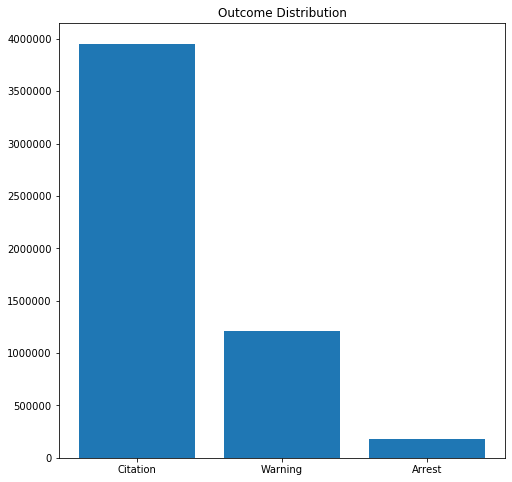

In [11]:
plot_d = {'Citation': np.sum(df_fl['outcome'] == 'citation'), 
          'Warning': np.sum(df_fl['outcome'] == 'warning'),
          'Arrest': np.sum(df_fl['outcome'] == 'arrest')}
labels = list(plot_d.keys())
values = list(plot_d.values())

fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(labels, values)
plt.title('Outcome Distribution')

## Explore and clean feature columns

Taking a look at violations, there is a vast amount of different descriptions, will have to aggregate these into subcategories if want to use a predictor

In [12]:
len(df_fl['violation'].value_counts())

35384

In [13]:
df_fl['violation'].value_counts()

SPEED                                                                                                                                       1934820
SEATBELT (DRIVER)                                                                                                                            201588
CMV INSPECTION                                                                                                                               182551
SPEED|PROOF OF INSURANCE                                                                                                                     161066
VIOLATIONS OF TRAFFIC CONTROL DEVICE                                                                                                         145366
                                                                                                                                             ...   
EXPIRED DRIVERS LICENSE (MORE THAN 4 MONTHS)|ATTACHING TAG NOT ASSIGNED|SEATBELT (DRIVER)                       

Looks like there are some duplicate counties due to upper/lower case differences. See if setting all to upper takes care of this -- there should be only 67 unique.

In [14]:
df_fl['county_name'].value_counts()

MIAMI-DADE    487762
PALM BEACH    433691
BROWARD       375960
ORANGE        369129
ST. LUCIE     188519
               ...  
ST JOHNS         354
Charlotte          2
THOMAS             1
Martin             1
BALDWIN            1
Name: county_name, Length: 73, dtype: int64

In [15]:
sum(df_fl['county_name']=='MARTIN')

89017

In [16]:
df_fl['county_name'] = df_fl['county_name'].apply(lambda x: x.upper())

In [17]:
sum(df_fl['county_name']=='MARTIN')

89018

In [18]:
len(df_fl['county_name'].unique())

72

Still some duplicates, need to take a closer look

In [19]:
df_fl['county_name'].unique()

array(['SARASOTA', 'DUVAL', 'ST. LUCIE', 'HERNANDO', 'BAY', 'GADSDEN',
       'LEON', 'CALHOUN', 'TAYLOR', 'MADISON', 'JEFFERSON', 'WAKULLA',
       'HAMILTON', 'COLUMBIA', 'PASCO', 'MARION', 'ALACHUA', 'SUWANNEE',
       'PALM BEACH', 'FRANKLIN', 'LIBERTY', 'SUMTER', 'MANATEE',
       'MIAMI-DADE', 'DIXIE', 'GILCHRIST', 'JACKSON', 'LEVY', 'LAFAYETTE',
       'ESCAMBIA', 'WASHINGTON', 'ST. JOHNS', 'SANTA ROSA', 'WALTON',
       'OKALOOSA', 'HARDEE', 'HOLMES', 'BAKER', 'BRADFORD', 'CLAY',
       'UNION', 'COLLIER', 'ORANGE', 'NASSAU', 'GULF', 'PUTNAM',
       'HIGHLANDS', 'FLAGLER', 'HILLSBOROUGH', 'CITRUS', 'LEE', 'POLK',
       'PINELLAS', 'VOLUSIA', 'BROWARD', 'DESOTO', 'CHARLOTTE', 'HENDRY',
       'GLADES', 'MONROE', 'INDIAN RIVER', 'SEMINOLE', 'LAKE', 'BREVARD',
       'OSCEOLA', 'OKEECHOBEE', 'MARTIN', 'ST LUCIE', 'ST JOHNS', nan,
       'BALDWIN', 'THOMAS'], dtype=object)

In [20]:
df_fl['county_name'].value_counts()

MIAMI-DADE    487762
PALM BEACH    433691
BROWARD       375960
ORANGE        369129
ST. LUCIE     188519
               ...  
GULF            3160
ST LUCIE         469
ST JOHNS         354
BALDWIN            1
THOMAS             1
Name: county_name, Length: 71, dtype: int64

St Lucie/St. Lucie and St. Johns are dupes. Looks like Thomas, Baldwin are not counties. That should take care of it.

In [21]:
df_fl.loc[df_fl['county_name']=='ST. LUCIE', 'county_name'] = 'ST LUCIE'
df_fl.loc[df_fl['county_name']=='ST. JOHNS', 'county_name'] = 'ST JOHNS'
df_fl = df_fl[df_fl['county_name'] != 'BALDWIN']
df_fl = df_fl[df_fl['county_name'] != 'THOMAS']

In [22]:
len(df_fl['county_name'].unique())

68

With some as nan, this is correct!

In [23]:
len(df_fl['vehicle_registration_state'].unique())

52

In [24]:
df_fl['vehicle_registration_state'].value_counts()

FL    3634798
GA      92256
AL      50010
TX      31626
TN      28586
NC      18327
NY      17609
LA      16429
IL      15749
IN      14495
SC      13840
OH      13659
PA      13300
NJ      12545
VA      11857
MS      11296
MI      10318
KY       7887
MD       7780
CA       7649
MA       6793
MO       5668
OK       5228
WI       4080
CT       3851
AZ       3343
AR       3210
MN       2692
CO       2567
IA       1873
WA       1736
NH       1614
KS       1513
ME       1468
NE       1362
RI       1349
WV       1325
DE       1166
NV       1076
NM       1018
OR        964
AK        763
UT        720
VT        624
MT        507
DC        452
SD        428
ID        413
ND        349
HI        247
WY        230
Name: vehicle_registration_state, dtype: int64

In [25]:
sum(df_fl['vehicle_registration_state'].isna())

1335705

State of registration is clean, although with many missing values. To use as category might be best to group into regions.

In [26]:
regions_d = {'AL': 'Southeast',
             'AK': 'Northwest',
             'AZ': 'Southwest',
             'AR': 'South',
             'CA': 'Pacific',
             'CO': 'Mountain',
             'CT': 'New England',
             'DE': 'Mid Atlantic',
             'FL': 'Instate',
             'GA': 'South Atlantic',
             'HI': 'Pacific',
             'ID': 'Mountain',
             'IL': 'Great Lakes',
             'IN': 'Great Lakes',
             'IA': 'Midwest',
             'KS': 'Midwest',
             'KY': 'South',
             'LA': 'South',
             'ME': 'New England',
             'MD': 'Mid Atlantic',
             'MA': 'New England',
             'MI': 'Great Lakes',
             'MN': 'Great Lakes',
             'MS': 'South',
             'MO': 'Midwest',
             'MT': 'Mountain',
             'NE': 'Midwest',
             'NV': 'Mountain',
             'NH': 'New England',
             'NJ': 'Mid Atlantic',
             'NM': 'Southwest',
             'NY': 'Mid Atlantic',
             'NC': 'South Atlantic',
             'ND': 'Midwest',
             'OH': 'Great Lakes',
             'OK': 'Southwest',
             'OR': 'Northwest',
             'PA': 'Mid Atlantic',
             'RI': 'New England',
             'SC': 'South Atlantic',
             'SD': 'Midwest',
             'TN': 'South',
             'TX': 'Southwest',
             'UT': 'Mountain',
             'VT': 'New England',
             'VA': 'South Atlantic',
             'WA': 'Northwest',
             'WV': 'South Atlantic',
             'WI': 'Great Lakes',
             'WY': 'Mountain'}

In [27]:
df_fl['vehicle_region'] = df_fl['vehicle_registration_state'].map(regions_d)

In [28]:
df_fl['vehicle_region'].value_counts()

Instate           3634798
South Atlantic     137605
South               67408
Great Lakes         60993
Mid Atlantic        52400
Southeast           50010
Southwest           41215
New England         15699
Midwest             11193
Pacific              7896
Mountain             5513
Northwest            3463
Name: vehicle_region, dtype: int64

## Examine missingness

Get a sense of how many nans are in each column

In [29]:
for col in df_fl.columns:
    num_missing = np.sum(df_fl[col].isna())
    print(f'{col} has {num_missing} missing values, about {np.round((num_missing/df_fl.shape[0])*100, 3)}%')

datetime has 0 missing values, about 0.0%
county_name has 1 missing values, about 0.0%
subject_age has 1328300 missing values, about 24.488%
subject_race has 1384 missing values, about 0.026%
subject_sex has 1317640 missing values, about 24.291%
officer_age has 996782 missing values, about 18.376%
officer_race has 1229230 missing values, about 22.661%
officer_sex has 745137 missing values, about 13.737%
officer_years_of_service has 423471 missing values, about 7.807%
violation has 422602 missing values, about 7.791%
outcome has 80060 missing values, about 1.476%
frisk_performed has 422592 missing values, about 7.791%
search_conducted has 426717 missing values, about 7.867%
search_basis has 5395618 missing values, about 99.47%
vehicle_registration_state has 1335705 missing values, about 24.624%
vehicle_region has 1336157 missing values, about 24.633%


In [30]:
#df_fl_sub = df_fl.drop(search_cols, axis=1)
#df_fl_dropnas = df_fl_sub.dropna() # df_fl_sub does not contain the search-related columns
#df_fl.shape[0] - df_fl_dropnas.shape[0]

A goddamn lot of missing data. The search related data is to be expected since searches are rare. But even after dropping search-related columns, if dropping all missing, we lose ~2.5m rows! But that still leaves about 2.8m. That would be a quick and dirty approach for but would like to retain some of these if possible.

Some ideas for handling missingness:
- subject age: impute mean or median
- subject race: negligible, drop missing
- subject sex: assume same ratio of males to females and impute accordingly
- officer age: impute mean or median
- officer race: yikes, this is a tough one, but would really like to use this feature
- officer sex: not as bad, but would like to retain, could impute expected ratio
- officer years of service: impute mean or median (likely median)
- violation: will need to aggregate anyway, can just throw missing into 'other' category
- frisk performed: assume false if missing
- search conducted: assume false if missing
- reason for search/search_basis: if search conducted 'other', if no search 'no search'
- vehicle_registration_state: 

For now (7/31) I will work with the nan-free dataset, but I do want to correct the values in the search-related columns, assuming if missing that no search/frisk was performed, and obviously no reason is given. Think I will drop reason given and just use search basis for simplicity's sake.

Confirming here that if a search was conducted, a basis was given, and vice versa. Below shows the number of bases given matches the number of searches.

In [31]:
df_fl['search_basis'].value_counts().values.sum()

28732

In [32]:
df_fl['search_conducted'].value_counts()

False    4968901
True       28732
Name: search_conducted, dtype: int64

Do some sanity checks regarding filling missing values with 'none' or False for the search columns.

In [33]:
df_fl_min['search_basis'].fillna('none').head()

0    none
1    none
2    none
3    none
4    none
Name: search_basis, dtype: object

In [34]:
df_fl_min['search_conducted'].fillna(False)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7      True
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
Name: search_conducted, dtype: bool

In [35]:
df_fl_min['frisk_performed'].fillna(False)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
Name: frisk_performed, dtype: bool

Now do it for real! Check for missingness like above afterwards.

In [36]:
df_fl['search_conducted'].fillna(False, inplace=True)
df_fl['search_basis'].fillna('none', inplace=True)
df_fl['frisk_performed'].fillna(False, inplace=True)

In [37]:
for col in df_fl.columns:
    num_missing = np.sum(df_fl[col].isna())
    print(f'{col} has {num_missing} missing values, about {np.round((num_missing/df_fl.shape[0])*100, 3)}%')

datetime has 0 missing values, about 0.0%
county_name has 1 missing values, about 0.0%
subject_age has 1328300 missing values, about 24.488%
subject_race has 1384 missing values, about 0.026%
subject_sex has 1317640 missing values, about 24.291%
officer_age has 996782 missing values, about 18.376%
officer_race has 1229230 missing values, about 22.661%
officer_sex has 745137 missing values, about 13.737%
officer_years_of_service has 423471 missing values, about 7.807%
violation has 422602 missing values, about 7.791%
outcome has 80060 missing values, about 1.476%
frisk_performed has 0 missing values, about 0.0%
search_conducted has 0 missing values, about 0.0%
search_basis has 0 missing values, about 0.0%
vehicle_registration_state has 1335705 missing values, about 24.624%
vehicle_region has 1336157 missing values, about 24.633%


## Clean 'violation' feature through aggregation

Now to clean up the violation column...
First step: just fill the nas as 'NR' for not recorded, see how many there are.

In [38]:
violation_filled = df_fl['violation'].fillna('NR')
violation_filled.value_counts()

SPEED                                                                                                                                       1934820
NR                                                                                                                                           422602
SEATBELT (DRIVER)                                                                                                                            201588
CMV INSPECTION                                                                                                                               182551
SPEED|PROOF OF INSURANCE                                                                                                                     161066
                                                                                                                                             ...   
EXPIRED DRIVERS LICENSE (MORE THAN 4 MONTHS)|ATTACHING TAG NOT ASSIGNED|SEATBELT (DRIVER)                       

In [39]:
violation_filled = violation_filled.str.split('|').str[0]

Consolidate violations...

In [40]:
violation_filled[violation_filled == 'SEATBELT (DRIVER)'] = 'SEATBELT'
violation_filled[violation_filled == 'SEATBELT (PASSENGER)'] = 'SEATBELT'
violation_filled[violation_filled == 'CHILD RESTRAINT'] = 'SEATBELT'

violation_filled[violation_filled == 'EXPIRED TAG (MORE THAN 6 MONTHS)'] = 'REGISTRATION OR TAG'
violation_filled[violation_filled == 'EXPIRED TAG (6 MONTHS OR LESS)'] = 'REGISTRATION OR TAG'
violation_filled[violation_filled == 'OTHER TAG / REGISTRATION VIOLATIONS'] = 'REGISTRATION OR TAG'
violation_filled[violation_filled == 'NO REGISTRATION'] = 'REGISTRATION OR TAG'
violation_filled[violation_filled == 'ATTACHING TAG NOT ASSIGNED'] = 'REGISTRATION OR TAG'

violation_filled[violation_filled == 'DRIVING WHILE LICENSE SUSPENDED / REVOKED'] = 'LICENSE'
violation_filled[violation_filled == 'OTHER DRIVERS LICENSE VIOLATIONS'] = 'LICENSE'
violation_filled[violation_filled == 'NO DRIVERS LICENSE'] = 'LICENSE'
violation_filled[violation_filled == 'FAILURE TO EXHIBIT DL UPON DEMAND'] = 'LICENSE'
violation_filled[violation_filled == 'EXPIRED DRIVERS LICENSE (4 MONTHS OR LESS)'] = 'LICENSE'
violation_filled[violation_filled == 'EXPIRED DRIVERS LICENSE (MORE THAN 4 MONTHS)'] = 'LICENSE'
violation_filled[violation_filled == 'VIOLATION OF DL RESTRICTIONS'] = 'LICENSE'
violation_filled[violation_filled == 'PERMIT VIOLATION'] = 'LICENSE'

violation_filled[violation_filled == 'IMPROPER TURN'] = 'IMPROPER DRIVING'
violation_filled[violation_filled == 'IMPROPER PASSING'] = 'IMPROPER DRIVING'
violation_filled[violation_filled == 'FOLLOWING TOO CLOSELY'] = 'IMPROPER DRVING'
violation_filled[violation_filled == 'IMPROPER CHANGE OF LANE OR COURSE'] = 'IMPROPER DRIVING'
violation_filled[violation_filled == 'CARELESS DRIVING'] = 'IMPROPER DRIVING'
violation_filled[violation_filled == 'VIOLATIONS OF RIGHT OF WAY'] = 'IMPROPER DRIVING'
violation_filled[violation_filled == 'IMPROPER BACKING'] = 'IMPROPER DRIVING'
violation_filled[violation_filled == 'IMPROPER START'] = 'IMPROPER DRIVING'

violation_filled[violation_filled == 'DUI'] = 'ALCOHOL'
violation_filled[violation_filled == 'DUI ARREST - JUVENILE'] = 'ALCOHOL'
violation_filled[violation_filled == 'JUVENILE .02 BAC SUSPENSION'] = 'ALCOHOL'
violation_filled[violation_filled == 'OPEN CONTAINER (DRIVER)'] = 'ALCOHOL'
violation_filled[violation_filled == 'OPEN CONTAINER (PASSENGER)'] = 'ALCOHOL'

violation_filled[violation_filled == 'FAULTY EQUIPMENT'] = 'VEHICLE'
violation_filled[violation_filled == 'EXHAUST SYSTEM'] = 'VEHICLE'
violation_filled[violation_filled == 'LOADS ON VEHICLE'] = 'VEHICLE'
violation_filled[violation_filled == 'BUMPER HEIGHTS'] = 'VEHICLE'
violation_filled[violation_filled == 'MOTOR VEHICLE NOISE'] = 'VEHICLE'
violation_filled[violation_filled == 'WINDOW TINT'] = 'VEHICLE'

violation_filled[violation_filled == 'BATTERY ON A POLICE OFFICER'] = 'AGGRAVATED'
violation_filled[violation_filled == 'RESISTING ARREST WITH / WITHOUT VIOLENCE'] = 'AGGRAVATED'
violation_filled[violation_filled == 'LEAVING THE SCENE'] = 'AGGRAVATED'
violation_filled[violation_filled == 'FLEEING AND ATTEMPTING TO ELUDE'] = 'AGGRAVATED'
violation_filled[violation_filled == 'FAILURE TO OBEY A POLICE OFFICER'] = 'AGGRAVATED'
violation_filled[violation_filled == 'RECKLESS DRIVING'] = 'AGGRAVATED'
violation_filled[violation_filled == 'DRIVING ON WRONG SIDE OF ROAD'] = 'AGGRAVATED'
violation_filled[violation_filled == 'FALSE ACCIDENT REPORT'] = 'AGGRAVATED'

violation_filled[violation_filled == 'CMV INSPECTION'] = 'COMMERCIAL'
violation_filled[violation_filled == 'CDL VIOLATION'] = 'COMMERCIAL'
violation_filled[violation_filled == 'MAXIMUM WIDTH, HEIGHT AND LENGTH'] = 'COMMERCIAL'
violation_filled[violation_filled == 'WEIGHT VIOLATION'] = 'COMMERCIAL'
violation_filled[violation_filled == 'DRIVER LOG VIOLATION'] = 'COMMERCIAL'
violation_filled[violation_filled == 'OUT OF SERVICE VIOLATION'] = 'COMMERCIAL'

violation_filled[violation_filled == 'OTHER NON MOVING VIOLATIONS'] = 'OTHER NON MOVING'
violation_filled[violation_filled == 'LEAVING CHILDREN UTTENDED IN MV'] = 'OTHER NON MOVING'
violation_filled[violation_filled == 'CRIMES AGAINST PERSONS'] = 'OTHER NON MOVING'
violation_filled[violation_filled == 'PROPERTY CRIMES'] = 'OTHER NON MOVING'
violation_filled[violation_filled == 'OTHER CRIMIL VIOLATIONS'] = 'OTHER NON MOVING'
violation_filled[violation_filled == 'OBSTRUCTING THE ROADWAY'] = 'OTHER NON MOVING'

violation_filled[violation_filled == 'MISCELLANEOUS MOTORCYCLE / MOPEDS STATUTES'] = 'OTHER'
violation_filled[violation_filled == 'BICYCLE VIOLATIONS'] = 'OTHER'
violation_filled[violation_filled == 'PASSING STOPPED SCHOOL BUS'] = 'OTHER'
violation_filled[violation_filled == 'PARKING'] = 'OTHER'
violation_filled[violation_filled == 'OTHER CRIMIL TRAFFIC VIOLATIONS'] = 'OTHER'

violation_filled[violation_filled == 'DRUG / CONTRABAND OFFENSE'] = 'CONTRABAND'

In [41]:
print(violation_filled.value_counts())
print(len(violation_filled.value_counts()))

SPEED                                   2709193
NR                                       422602
SEATBELT                                 421578
VEHICLE                                  304454
REGISTRATION OR TAG                      283770
COMMERCIAL                               260361
VIOLATIONS OF TRAFFIC CONTROL DEVICE     202270
OTHER MOVING VIOLATIONS                  152400
PROOF OF INSURANCE                       133109
IMPROPER DRIVING                         131723
LICENSE                                  131179
MOVE OVER LAW                             86800
OTHER NON MOVING                          83064
IMPROPER DRVING                           30314
DRIVING WITHOUT HEADLIGHTS                26527
TOLL EVASION                              12393
ALCOHOL                                   11925
OTHER                                      8711
AGGRAVATED                                 7088
CONTRABAND                                 4889
Name: violation, dtype: int64
20


Whew, twenty seems like a good number, and even with the small numbers, the contraband, aggravated, alcohol categories should carry information. Now assign this back to the violation column.

In [42]:
df_fl['violation'] = violation_filled

In [43]:
df_fl['violation'].head(10)

0                  NR
1               SPEED
2             ALCOHOL
3             LICENSE
4                  NR
5                  NR
6               SPEED
7             VEHICLE
8    OTHER NON MOVING
9                  NR
Name: violation, dtype: object

## Check numerical columns for outliers

Forgot to do this before, but need to check the age columns for outliers.

In [44]:
df_fl['subject_age'].min()

10.0

In [45]:
df_fl['subject_age'].max()

110.0

Assume anything under 16 and over 90 is an outlier.

In [46]:
df_fl = df_fl[df_fl['subject_age'] >= 16]
df_fl = df_fl[df_fl['subject_age'] <= 90]

In [47]:
print(df_fl['subject_age'].min())
print(df_fl['subject_age'].max())

16.0
90.0


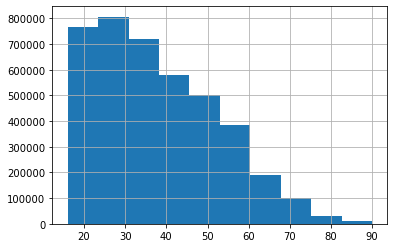

In [48]:
df_fl['subject_age'].hist()

Check out officer age

In [49]:
df_fl['officer_age'].describe()

count    3.296237e+06
mean     3.806216e+01
std      9.685584e+00
min      1.600000e+01
25%      3.000000e+01
50%      3.800000e+01
75%      4.600000e+01
max      6.900000e+01
Name: officer_age, dtype: float64

Assume youngest officer is 18

In [50]:
df_fl = df_fl[df_fl['officer_age'] >= 18]

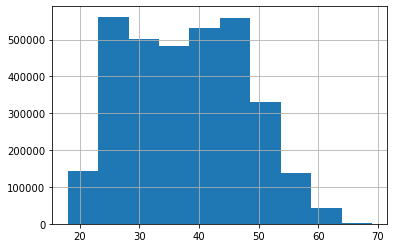

In [51]:
df_fl['officer_age'].hist()

Looks ok, check out officer years of service

In [52]:
df_fl['officer_years_of_service'].describe()

count    3.294672e+06
mean     5.482477e+00
std      6.943282e+00
min     -6.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      9.000000e+00
max      6.000000e+01
Name: officer_years_of_service, dtype: float64

In [53]:
sum(df_fl['officer_years_of_service'] < 0)

16551

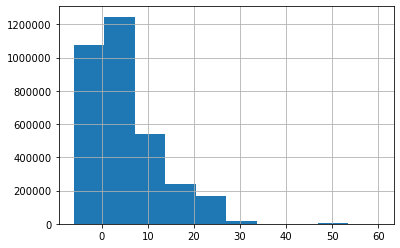

In [54]:
df_fl['officer_years_of_service'].hist()

In [55]:
neg_off_years = df_fl[df_fl['officer_years_of_service'] < 0]

In [56]:
neg_off_years.head()

,datetime,county_name,subject_age,subject_race,subject_sex,officer_age,officer_race,officer_sex,officer_years_of_service,violation,outcome,frisk_performed,search_conducted,search_basis,vehicle_registration_state,vehicle_region
330,2010-01-23 12:11:16,LEON,47.0,black,female,53.0,white,male,-5.0,PROOF OF INSURANCE,citation,False,False,none,FL,Instate
331,2010-01-23 12:11:51,LEON,47.0,black,female,53.0,white,male,-5.0,PROOF OF INSURANCE,citation,False,False,none,FL,Instate
337,2010-01-23 12:33:08,LEON,25.0,white,female,53.0,white,male,-5.0,VEHICLE,warning,False,False,none,FL,Instate
341,2010-01-23 12:50:16,LEON,24.0,hispanic,male,53.0,white,male,-5.0,SEATBELT,citation,False,False,none,FL,Instate
347,2010-01-23 13:06:11,LEON,56.0,black,female,53.0,white,male,-5.0,LICENSE,citation,False,False,none,FL,Instate


Given the officer ages, looks like the negative signs are just an error. Assume the absolute value is correct.

In [57]:
df_fl['officer_years_of_service'] = np.abs(df_fl['officer_years_of_service'])

## Create features for day of week, month, and time of day

Create day of week, month, and time bin columns.

In [58]:
df_fl['day_of_week'] = df_fl['datetime'].dt.day_name()
df_fl['month'] = df_fl['datetime'].dt.month_name()
df_fl['time_of_day'] = pd.cut(df_fl['datetime'].dt.hour, [0,5,10,16,20,24], 
                              labels=['EarlyMorning','MorningRush','Midday','EveningRush', 'LateNight'])

In [59]:
df_fl.head()

,datetime,county_name,subject_age,subject_race,subject_sex,officer_age,officer_race,officer_sex,officer_years_of_service,violation,outcome,frisk_performed,search_conducted,search_basis,vehicle_registration_state,vehicle_region,day_of_week,month,time_of_day
1,2010-01-06 16:14:43,DUVAL,23.0,white,female,31.0,black,male,8.0,SPEED,citation,False,False,none,NC,South Atlantic,Wednesday,January,Midday
2,2010-01-08 19:39:31,DUVAL,45.0,white,female,29.0,white,male,3.0,ALCOHOL,arrest,False,False,none,FL,Instate,Friday,January,EveningRush
3,2010-01-11 11:56:34,ST LUCIE,41.0,white,male,26.0,white,male,3.0,LICENSE,arrest,False,False,none,FL,Instate,Monday,January,Midday
6,2010-01-15 09:18:02,GADSDEN,26.0,white,male,47.0,white,male,0.0,SPEED,warning,False,False,none,NY,Mid Atlantic,Friday,January,MorningRush
7,2010-01-15 10:16:59,GADSDEN,42.0,hispanic,male,47.0,white,male,0.0,VEHICLE,NaN,False,True,consent,FL,Instate,Friday,January,MorningRush


Now, check how many rows we keep if we drop all missing values.

In [60]:
df_fl_dropnas = df_fl.dropna()
print(df_fl_dropnas.shape)
print(df_fl.shape[0] - df_fl_dropnas.shape[0])

(2805687, 19)
489509


Ok, so looks like the vast majority of rows we dropped above were dropped here also. Too bad, but at least the violation column is cleaned up.

## Save full and NA-free versions of dataset

Now save both the na-populated and na-free data-frames. Use na-free for now for EDA and modeling. Circle back to na-populated for imputation, time-permitting, and/or for use with tree-based models.

In [61]:
df_fl_full_clean = df_fl.copy()
del df_fl

In [62]:
pickle.dump(df_fl_full_clean, open('data/df_fl_full_clean.pkl', 'wb'))
pickle.dump(df_fl_dropnas, open('data/df_fl_dropnas.pkl', 'wb'))

## Quick pairplot to see target-feature relationship 

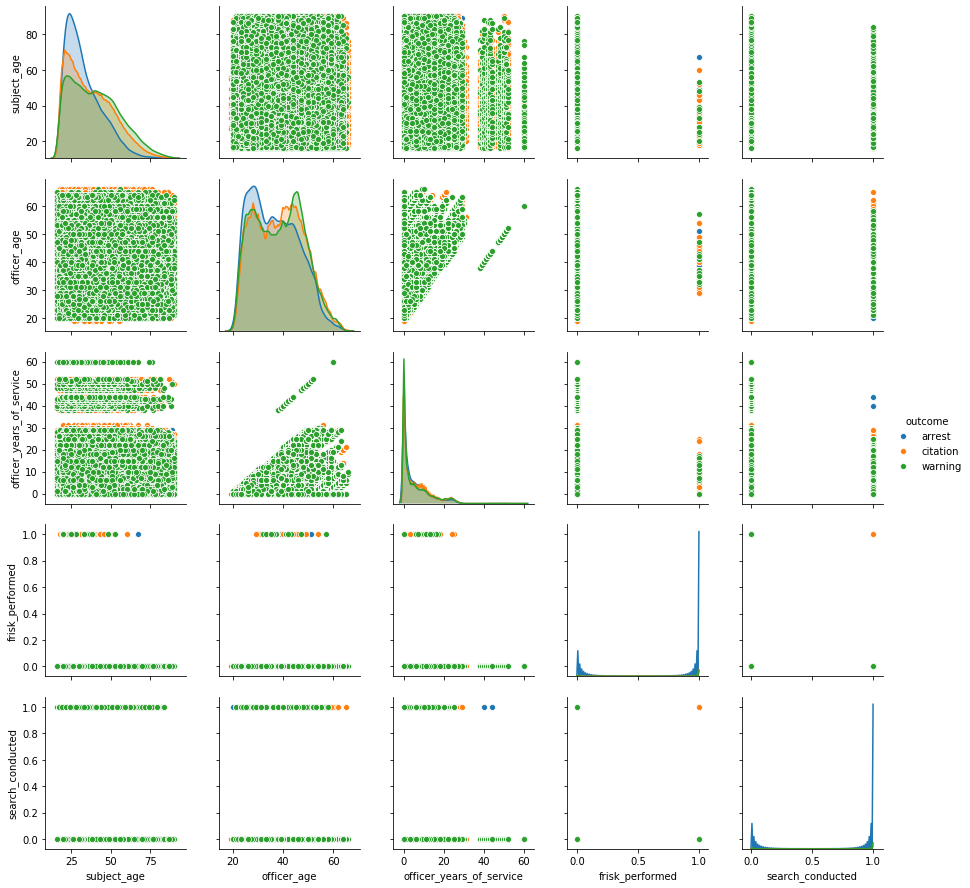

In [63]:
sns.pairplot(df_fl_dropnas, hue='outcome')

In [40]:
def impute_age(df, col, method):
    if method=='mean':
        df[col] = df[col].fillna(df[col].mean())
    elif method=='median':
        df[col] = df[col].fillna(df[col].median())
    return df

In [51]:
def missing_to_false(df, cols, fillval='False'):
    """
    Replaces missing values with fillval
    
    fillval = 'False' by default, else choose 0
    """
    for col in cols:
        df[col].fillna(fillval)
    return df

In [ ]:
def plot_features(df, sample_size=1000, drop_cols=None):
    if drop_cols:
        sample = (df.drop(['product_id','user_id','latest_cart'], axis=1)
                .sample(sample_size, random_state=44)) 
    else:
        sample = df.sample(sample_size, random_state=44)
        sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_X)